In [1]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("../../")

In [3]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 26 s, sys: 6.77 s, total: 32.8 s
Wall time: 33.1 s


In [4]:
N_max = -1
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [5]:
from phenixml.featurizers.fingerprints import MorganFeaturizer

In [6]:
def worker_angle(angle_fragment):
  angle_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return angle_featurizer.featurize(angle_fragment)

def worker_bond(bond_fragment):
  bond_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return bond_featurizer.featurize(bond_fragment)

In [7]:
# work = angle_fragments
# with closing(Pool(processes=32)) as pool:
#   angle_features = []
#   for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
#       angle_features.append(result)
#   pool.terminate()

In [8]:
work = bond_fragments
with closing(Pool(processes=16)) as pool:
  bond_features = []
  for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
      bond_features.append(result)
  pool.terminate()

100%|██████████| 1856810/1856810 [00:00<00:00, 2679225.27it/s]


In [12]:
bond_features = np.array(bond_features)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [14]:
space = np.arange(len(bond_fragments))
keep, drop = train_test_split(space,test_size=0.5)

In [ ]:
mode = "bond"
if mode =="bond":
  frags = [bond_fragments[i] for i in keep]
  X = bond_features[keep]
  y =  np.array([bond_fragments[i].properties["bond_length"] for i in keep])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [frags[i] for i in train], [frags[i] for i in test]
elif mode == "angle":
  frags = [angle_fragments[i] for i in keep]
  X = angle_features[keep]
  y =  np.array([angle_fragments[i].properties["angle_deg"] for i in keep])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [frags[i] for i in train], [frags[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [28]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=0.1,min_samples_leaf= random_state=0,n_jobs=-1)

In [34]:
keep

array([ 215197,  189423, 1327340, ...,  761635, 1695924,  833163])

In [29]:
%%time
regressor.fit(X_train,y_train)


KeyboardInterrupt



In [14]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

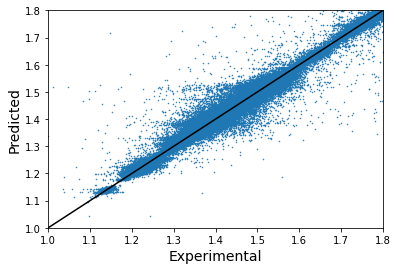

In [15]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

(-0.2, 0.2)

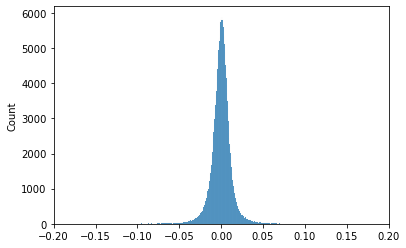

In [22]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
residuals = y_test-y_pred
sns.histplot(residuals)
plt.xlim(-0.2,0.2)

In [18]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 0.016317799506657193


In [19]:
from phenixml.utils.eval_utils import tukey_test

In [20]:
from phenixml.utils.eval_utils import tukey_test
outliers_prob,outliers_poss = tukey_test(residuals)
print(len(outliers_poss),(len(outliers_poss)/len(y_test))*100)
print(len(outliers_prob),(len(outliers_prob)/len(y_test))*100)

23361 6.290627474001109
6784 1.8267889552512104


In [23]:
print(len(X))

1856810


In [24]:
len(bond_fragments)

1856810

In [25]:
# Dump model to disk
from joblib import dump, load
dump_path = Path("../../examples/pre_trained_models/ecfp_bonds_rf_pretrained.pkl")
with dump_path.open("wb") as fh:
  dump(regressor,fh)

In [30]:
dump?


KeyboardInterrupt

